In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\nilec\Venvs\ds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CNN Model - Grayscale Images

In [3]:
class LeNet(nn.Module):

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)     # input image has 1 channel (grayscale), output has 6 channels, and the kernel is a 3x3 matrix
        self.conv2 = nn.Conv2d(6, 16, 3)    # outputs 16 feature maps per image, 3x3 kernel 
        self.fc1 = nn.Linear(16*6*6, 120)   # 16*6*6 input dimension after linearizing the feature maps, output 120
        self.fc2 = nn.Linear(120, 84)       
        self.fc3 = nn.Linear(84, 10)        # output 10, each for a numerical digit

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        # linearize the feature maps for the feed forward layer
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


### Test the forward pass

In [4]:
model = LeNet()
print(model)

input = torch.rand(1, 1, 32, 32)      # 1 image of 32 X 32 px single-channel (grayscla) image
print("Input shape: {}".format(input.shape))

output = model(input)       # pass the input through the model and get the result
print("Output: {}".format(output))      # model.forward() is not explicitly called


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Input shape: torch.Size([1, 1, 32, 32])
Output: tensor([[ 0.0029, -0.0032,  0.0182, -0.0416,  0.1281,  0.0201, -0.1380,  0.0972,
         -0.0436,  0.0422]], grad_fn=<AddmmBackward0>)


### Preparing a dataset

In [5]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# the following transform object performs the ToTensor() operation to the image followed by the normalization. ToTensor() also works on numpy.ndarray
# convert loaded image to equivalent 2D tensors using ToTensor()
# normalization with mean 0, sd 0.5 for all three channels (RGB)
transform = transforms.Compose([transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


In [7]:
# access the CIFAR10 dataset. Download in project root folder if required using 'download=True' as a parameter.
# if train=True, the dataset is created from the training set. Otherwise, it is created from the testing set
# perform transformation on data using the previously created transform object
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform)
# Finally, load the dataset using the DataLoader. num_workers=2 speeds up the loading process of images for training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [8]:
def imshow(img):
    img = img/2 + 0.5       # revert the previous normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_iter = iter(trainloader)
# obtain the next set of 4 images
images, labels = next(data_iter)

horse bird cat truck 


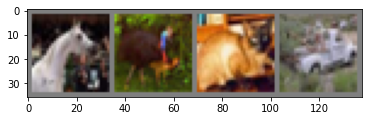

In [9]:
# print the images and labels
imshow(torchvision.utils.make_grid(images))
print("".join("{} ".format(classes[label]) for label in labels))

#### CNN model for 3-channel images

In [10]:
class Net(nn.Module):

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)     # input image has 1 channel (grayscale), output has 6 channels, and the kernel is a 3x3 matrix
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)    # outputs 16 feature maps per image, 3x3 kernel 
        self.fc1 = nn.Linear(16*5*5, 120)   # 16*6*6 input dimension after linearizing the feature maps, output 120
        self.fc2 = nn.Linear(120, 84)       
        self.fc3 = nn.Linear(84, 10)        # output 10, each for a numerical digit

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)      # linearization
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

In [11]:
loss_F = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
transform = transforms.Compose([transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# train set
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# test set
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Training the model

In [16]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        # 
        outputs = net(inputs)
        loss = loss_F(outputs, labels)
        loss.backward()
        optimizer.step()
        #
        running_loss += loss.item()
        if i%2000 == 1999:
            print("[{}, {}] loss: {:.3f}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print("Training is done.")

[1, 2000] loss: 1.636
[1, 4000] loss: 1.571
[1, 6000] loss: 1.520
[1, 8000] loss: 1.450
[1, 10000] loss: 1.397
[1, 12000] loss: 1.378
[2, 2000] loss: 1.291
[2, 4000] loss: 1.302
[2, 6000] loss: 1.266
[2, 8000] loss: 1.248
[2, 10000] loss: 1.246
[2, 12000] loss: 1.230
Training is done.


#### Test the model on unseen images

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on the 10k test images: {}%%".format(100*correct/total))

Accuracy on the 10k test images: 57.61%%
